# AutoInt 모델 구현 및 학습

In [1]:
import time
import random
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import math

### Layer 정의
AutoInt에 사용되는 Layer는 총 3가지입니다.

1. 임베딩 레이어
    * 임베딩 레이어는 raw input 데이터를 저차원 임베딩 공간에 매핑하는 과정을 의미합니다.
    * 예를 들어 성별이 남, 여가 있다면 이는 각각 0과 1로 매핑될 수 있고, 0에 해당되는 32차원 임베딩 공간, 1에 해당되는 임베딩 공간에 매핑하는 과정이죠.
2. 다층 퍼셉트론(MLP-Multilayer Perceptron, DNN 구조)
    * 딥러닝을 배우면 거의 가장 먼저 배울 수 있는 구조입니다.
    * 비선형 레이어를 쌓아올린 구조입니다. Dense layer를 쌓아올린 구조라고 보시면 됩니다.
3. 멀티 헤드 어텐션
    * 쿼리(query), 키(key), 값(value)에 따른 어텐션을 계산하는 구조입니다.
    * 본 모델에서는 셀프 어텐션 구조로 진행됩니다.

##### 임베딩 레이어

In [2]:
class FeaturesEmbedding(Layer):  
    '''
    임베딩 레이어입니다. 
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 됩니다.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성되게 됩니다.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.longlong)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        # 임베딩을 빌드하고 초기화합니다.
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        # 들어온 입력의 임베딩을 가져니다.
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

##### 다층 퍼셉트론

In [3]:
class MultiLayerPerceptron(Layer):  
    '''
    DNN 레이어입니다.
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조입니다.
    - 필요에 따라 배치 정규화도 사용할 수 있습니다.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]
        # Dense layer를 쌓아올립니다.
        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        # 활성화 함수를 세팅합니다.
        self.activation = tf.keras.layers.Activation(activation)
        # 필요하다면 배치정규화도 진행합니다.
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            # input data가 들어오면 layer를 돌면서 벡터 값을 가져오게 됩니다.
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            # 각 layer마다 나온 벡터 값에 활성화 함수와 dropout을 적용시켜 비선형성 구조와 과적합을 방지합니다.
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

##### 멀티 헤드 어텐션

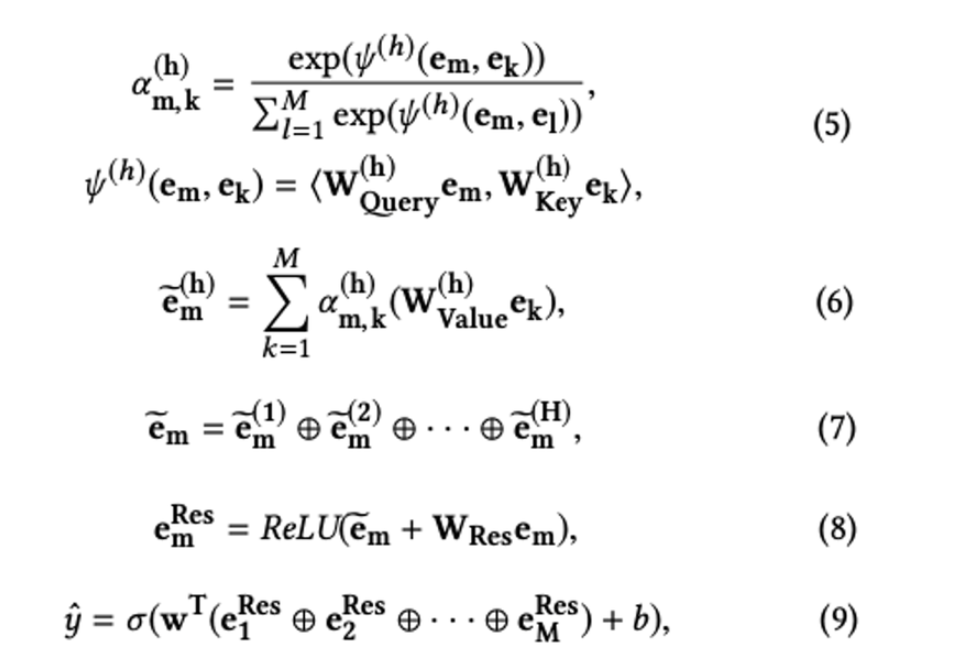

In [4]:
class MultiHeadSelfAttention(Layer):  
    '''
    멀티 헤드 셀프 어텐션 레이어입니다.
    - 위에 작성한 수식과 같이 동작됩니다.
    - 필요에 따라 잔차 연결(residual connection)도 진행합니다.
    '''
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        # 쿼리에 해당하는 매트릭스입니다. 
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        # 키에 해당되는 매트릭스입니다.
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        # 값(value)에 해당되는 매트릭스입니다.
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        # 필요하다면 잔차 연결도 할 수 있습니다.
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        
        # 입력이 들어오면 쿼리, 키, 값(value)에 매칭되어 각각의 값을 가지고 옵니다.
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        # 헤드 개수에 따라 데이터를 분리해줍니다.
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # 쿼리와 키를 먼저 곱해줍니다. 위 이미지의 식 (5)와 같습니다.
        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)
        
        # 쿼리와 키에서 나온 어텐션 값을 값(value)에 곱해줍니다. 식 (6)과 같습니다.
        result = tf.matmul(self.normalized_att_scores, values)
        # 식 (7)과 같이 쪼개어진 멀테 헤드를 모아줍니다.
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)
        
        # 그 결과 값을 리턴합니다.

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config

### AutoInt 모델


In [5]:
class AutoInt(Layer): 
    '''
     AutoInt 본체입니다. 앞서서 정의한 layer를 가져와서 계산을 수행합니다.
    '''
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, 
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoInt, self).__init__()
        # 임베딩 레이어를 정의합니다. 
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size
        # 마지막 출력 레이어를 정의합니다.
        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        # 멀티 레이어 퍼셉트론 레이어를 정의합니다.
        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res) for _ in range(att_layer_num)]

    def call(self, inputs):
        # input 데이터에 해당되는 embedding 값을 가져옵니다.
        att_input = self.embedding(inputs)
        # 멀티 헤드 셀프 어텐션 레이어에서 상호작용을 수행합니다.
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        # 최종 출력입니다. 
        att_output = self.final_layer(att_output)
        # sigmoid로 예측값을 출력합니다.
        y_pred = tf.nn.sigmoid(att_output)

        return y_pred

### 평가 지표


In [6]:
# 평가 함수는 아래의 링크에서 가져왔습니다.
# https://www.programcreek.com/python/?code=MaurizioFD%2FRecSys2019_DeepLearning_Evaluation%2FRecSys2019_DeepLearning_Evaluation-master%2FConferences%2FKDD%2FMCRec_our_interface%2FMCRecRecommenderWrapper.py
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

### 모델 테스트


In [7]:
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

### 데이터 불러오기 및 세팅
전처리하였던 데이터를 불러옵니다. 이 데이터를 모델에 바로 사용할 수 없는데요. 모델 input으로 넣어 학습하기 위해서는 다음과 같은 과정을 거쳐야 합니다.

1. 데이터 불러오기
2. 레이블 인코더(label encoder)를 통해 0부터 피처(feature)의 고유 개수까지 매핑
    * 예) 성별: 남(M), 여(F)를 0, 1로 변환
    * 예) 장르: 코메디, 드라마, 액션을 0, 1, 2로 변환
3. 학습(train) 데이터와 테스트(test) 데이터로 분리

In [9]:
# 1. 데이터 불러오기
# csv 데이터이므로 read_csv로 가져옵니다.
data_path = './autoint/ml-1m'

movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [10]:
# 2. 라벨 인코더(label encoder)
# sklearn의 LabelEncoder(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
# label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킵니다.
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

In [11]:
movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,55,1,0,0,7,17,15,0,0,2,1588,1
1,0,3374,8,76,1,0,0,2,2,8,0,0,2,1588,0
2,0,3615,5,44,1,0,0,11,12,15,0,0,2,1588,0
3,0,2503,9,80,1,0,0,7,17,15,0,0,2,1588,1
4,0,1374,8,78,1,0,0,2,2,2,0,0,2,1588,1


In [12]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

In [13]:
# 3. 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int64  
 1   movie_id       800167 non-null  int64  
 2   movie_decade   800167 non-null  int64  
 3   movie_year     800167 non-null  int64  
 4   rating_year    800167 non-null  int64  
 5   rating_month   800167 non-null  int64  
 6   rating_decade  800167 non-null  int64  
 7   genre1         800167 non-null  int64  
 8   genre2         800167 non-null  int64  
 9   genre3         800167 non-null  int64  
 10  gender         800167 non-null  int64  
 11  age            800167 non-null  int64  
 12  occupation     800167 non-null  int64  
 13  zip            800167 non-null  int64  
 14  label          800167 non-null  float32
dtypes: float32(1), int64(14)
memory usage: 94.6 MB


In [15]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는  임베딩 때 활용됩니다. 
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439])

### 훈련 환경 및 모델 세팅
1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

In [16]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs=5
learning_rate= 0.0001
dropout= 0.4
batch_size = 2048
embed_dim= 16

In [17]:
# AutoInt 레이어를 가지고 있는 모델 본체입니다. 해당 모델을 활용해 훈련을 진행합니다.
class AutoIntModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2
                 , att_res=True, l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                 , dnn_dropout=0, init_std=0.0001):
        super(AutoIntModel, self).__init__()
        self.autoInt_layer = AutoInt(field_dims, embedding_size, att_layer_num=att_layer_num, att_head_num=att_head_num, 
                                     att_res=att_res, l2_reg_dnn=l2_reg_dnn, dnn_dropout=dnn_dropout, init_std=init_std
                                    )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

In [18]:
# 모델 정의
autoInt_model = AutoIntModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                             l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                             , dnn_dropout=dropout, init_std=0.0001)

In [19]:
# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

In [20]:
autoInt_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_crossentropy'])

### 훈련 및 평가
훈련 후에는 NDCG와 Hitrate를 활용해 평가를 진행합니다.

In [21]:
history = autoInt_model.fit(train_df[u_i_feature + meta_features], train_df[label], epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - binary_crossentropy: 0.6873 - loss: 0.6873 - val_binary_crossentropy: 0.6487 - val_loss: 0.6487
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - binary_crossentropy: 0.6364 - loss: 0.6364 - val_binary_crossentropy: 0.5995 - val_loss: 0.5995
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - binary_crossentropy: 0.5846 - loss: 0.5846 - val_binary_crossentropy: 0.5510 - val_loss: 0.5510
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - binary_crossentropy: 0.5442 - loss: 0.5442 - val_binary_crossentropy: 0.5437 - val_loss: 0.5437
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - binary_crossentropy: 0.5362 - loss: 0.5362 - val_binary_crossentropy: 0.5413 - val_loss: 0.5413


In [22]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}
# top10개
top = 10
# 테스트 값을 가지고 옵니다. 
mymodel_user_pred_info = test_model(autoInt_model, test_df)
# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

C:\Users\lee.eunjeong\AppData\Local\Temp\ipykernel_2756\2567990266.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
100%|██████████| 6038/6038 [00:00<00:00, 87687.82it/s]


In [23]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 48402.06it/s]


In [24]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.66165
 mymodel hitrate :  0.62995


### 저장

In [25]:
np.save('./autoint/field_dims.npy', field_dims)

In [26]:
# 모델 저장을 위해, autoint 폴더 안에 model 폴더를 생성합니다.
!mkdir ./autoint/model/

���� ������ �ùٸ��� �ʽ��ϴ�.


모델의 가중치(weight)를 저장

In [28]:
autoInt_model.save_weights('./autoint/model/autoInt_model.weights.h5')

모델을 저장할 때는 모델 객체도 저장해 두어야 합니다. 모델 객체는 joblib.dump를 이용하여 pickled binary file 형태로 저장하면 됩니다.

In [29]:
import joblib 

# 모델 객체를 pickled binary file 형태로 저장
joblib.dump(label_encoders, './autoint/label_encoders.pkl')

['./autoint/label_encoders.pkl']